In [1]:
import numpy as np
from random import random
from math import sin, pi, cos
from cmath import exp as e,  sinh
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
FC = 20
FS = 600
TS = 1/FS
M = 31
LENGTH = 2*M + 1
WC = 2*pi*(FC/FS)

In [3]:
def genIN():
    INPUT = np.zeros(40*LENGTH)
    for n in range(40*LENGTH):
        INPUT[n] = sin(1*pi*n/LENGTH) + random()%0.5 + (1/(n+1)) + sin(2*pi*n/LENGTH) - sin(3*pi*n/LENGTH)   
    0
    return INPUT
        

In [4]:
IN = genIN()

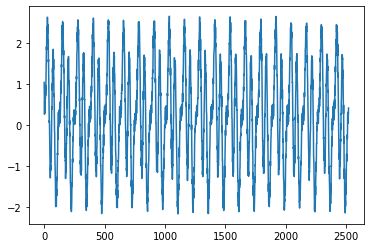

In [5]:
plt.plot(IN)

In [6]:
def sample(f,n):
    '''
    Discretize function
    '''
    return f(n*TS)

In [7]:
def DTFT(h,W,LowLim,HighLim, typ = 'cont'):
    '''
    Calculate DTFT of a given function
    
    cont : continuous time function
    vector : a single vector 
    
    '''
    HW = 0
    
    if typ == 'cont':
        for n in range(LowLim,HighLim):
            HW += sample(h,n)*e(-1j*W*n)
            
    elif typ == 'vector':
        for n in range(LowLim,HighLim):
            HW += (h[n])*e(-1j*W*n)
    
    
    return HW


def IDTFT(G,n,res=100):
    '''
    Inverse DT Fourier Transform 
    res = resolution 
    '''
    
    w,dw = np.linspace(-pi,pi,num = res, retstep = True)
    h = 0

    for i in range(len(w)-1):
        h += (G(w[i]) *e(1j*w[i]*n)) #+ (G(w[i+1])*e(1j*w[i+1]*n))
        
    h = h*(dw/(2*pi))
    
    return h
    

In [8]:
class CBuff:
    def __init__(self):
        
        self.buffer = np.zeros(LENGTH,dtype = 'complex')    # Creating buffer 
        self.index  = 0                   # seting index to 0
        self.out    = 0                   # setting output to 0
        
    def clear(self):
        self.index = 0
        self.buffer = np.zeros(LENGTH)
        
    
    def getOUT(self,IN,h):
        # puting input into buffer 
        self.buffer[self.index] = IN
        
        #increasing buffer index 
        self.index += 1
        
        #wrap the index
        self.index = self.index % LENGTH
        
        #calculate output 
        self.out = 0
        sumIDX = self.index
        for n in range(LENGTH):
            # wrap sumIDX
            if sumIDX :
                sumIDX -= 1
            else :
                sumIDX = LENGTH - 1
            # Convolute inpulse response and input buffer     
            self.out += h[n]*self.buffer[sumIDX] 
            
        return self.out
    
        
        
        

In [9]:
def trigWINDOW(n):
    '''
    Triangular WINDOW , Bartlett
    
    '''
    if (1 - (abs(n-LENGTH/2)/(LENGTH/2))) > 0:
        return  (1 - abs(n-LENGTH/2)/(LENGTH/2))
    return 0
    

In [10]:
def parzenW(n):
    if abs(n) <= (LENGTH/4) :
        A = 1- 6 * (1 - abs(n) /(LENGTH/2)) * (n/(LENGTH/2)) ** 2
        
    else :
        A = 2* (1-abs(n)/(LENGTH/2)) **3
    
    return A
    
def parzen(n):
    return parzenW(n-M)

In [11]:
def welch(n):
    '''
    Welch Window 
    '''
    return  1-((2*(n/LENGTH))-1)**2

In [12]:
def sinW(n):
    '''
    SINE WINDOW
    '''
    return sin(pi*n/LENGTH)

In [13]:
def POS(n,alpha):
    return sinW(n) ** alpha

In [14]:
def BM1(n,alpha):
    a0 = (1-alpha)/2
    a1 = 1/2
    a2 = alpha/2
    
    return a0 - a1* cos(2*pi*n/LENGTH) + a2*cos(4*pi*n/LENGTH)



In [15]:
def nuttall(n):
    a = np.array([0.355768,0.487396,0.144232,0.012604])
    return a[0] - a[1]*cos(2*pi*n/LENGTH) + a[2]*cos(4*pi*n/LENGTH) - a[3]*cos(6*pi*n/LENGTH)


def nuttall_BM(n):
    a = np.array([0.3635819,0.4891775,0.1365995,0.0106411])
    return a[0] - a[1]*cos(2*pi*n/LENGTH) + a[2]*cos(4*pi*n/LENGTH) - a[3]*cos(6*pi*n/LENGTH)

def Blackman_Harris(n):
    a = np.array([0.35875,0.48829,0.14128,0.01168])
    return a[0] - a[1]*cos(2*pi*n/LENGTH) + a[2]*cos(4*pi*n/LENGTH) - a[3]*cos(6*pi*n/LENGTH)

def flat_top(n):
    a = np.array([0.21557895,0.41663158,0.277263158,0.083578947,0.006947368])
    return a[0] - a[1]*cos(2*pi*n/LENGTH) + a[2]*cos(4*pi*n/LENGTH) - a[3]*cos(6*pi*n/LENGTH) + a[4]*cos(8*pi*n/LENGTH)

In [57]:
def genNORM(n,P,div):
    '''Gernalized Normal Window'''
    k = 2*n/LENGTH
    value = e(-((k - 1 )/(div)) ** P)
    return value
    

In [70]:
def Turkey(n,a):
    if n < a*LENGTH/2:
        return 0.5*(1 - cos(2*pi*n/(a*LENGTH)))
    elif n < LENGTH/2:
        return 1
    else:
        return Turkey(LENGTH-n,a)

In [93]:
def plank(n,E):
    '''Plank Tapper window'''
    if n ==0:
        return 0
    elif n < E*LENGTH:
        g = (E*LENGTH/n) - (E*LENGTH/(E*LENGTH - n))
        return 1/(1 + e(g))
    elif n < LENGTH/2:
        return 1
    else:
        return plank(LENGTH-n,E)

In [85]:
def H(w):
    '''
    IDEAL LOWPASS FREQUENCY RESPONSE 
    '''

    if abs(w) < WC  :
        return 1
    return 0

In [86]:
LOW =  -LENGTH
HIGH =  LENGTH
N = range(int(LOW),int(HIGH)+1)
chkR = np.zeros(len(N),dtype='complex')
for n in range(len(N)) :
    chkR[n] = IDTFT(H,N[n],res = 2*HIGH)


Text(0.5, 1.0, 'WELCH')

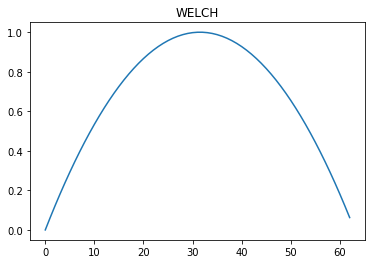

In [87]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = welch(i)
    
plt.plot(pz)
plt.title('WELCH')

Text(0.5, 1.0, 'Turkey')

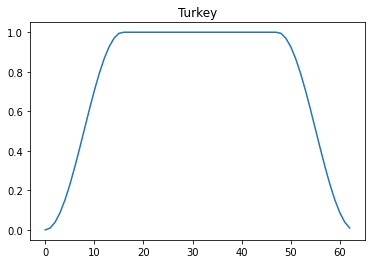

In [88]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = Turkey(i,0.5)
    
plt.plot(pz)
plt.title('Turkey')

Text(0.5, 1.0, 'Turkey')

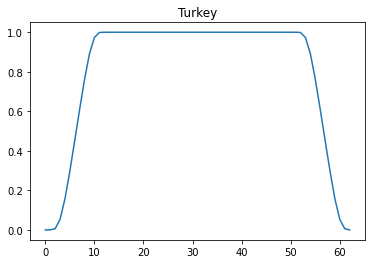

In [95]:
pz = np.zeros(LENGTH,dtype = complex)
for i in range(LENGTH):
    pz[i] = plank(i,0.2)
    
plt.plot(pz.real)
plt.title('Turkey')

Text(0.5, 1.0, 'PARZEN')

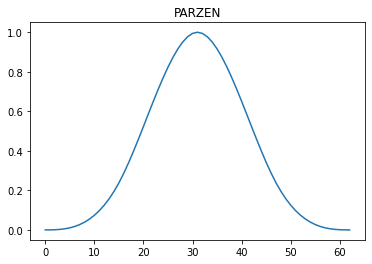

In [19]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = parzen(i)
    
plt.plot(pz)
plt.title('PARZEN')

Text(0.5, 1.0, 'Triangular')

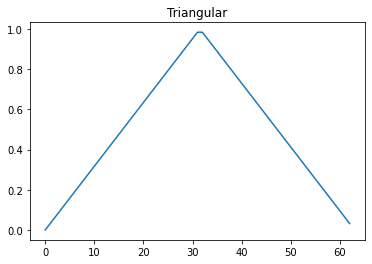

In [20]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = trigWINDOW(i)
    
plt.plot(pz)
plt.title('Triangular')

Text(0.5, 1.0, 'SINE')

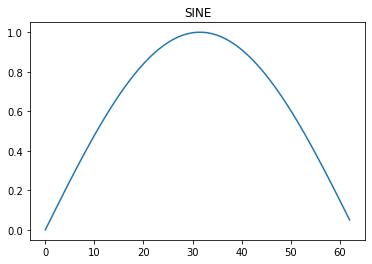

In [21]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = sinW(i)
    
plt.plot(pz)
plt.title('SINE')

Text(0.5, 1.0, 'POWER OF SINE')

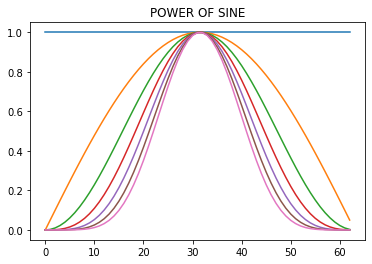

In [22]:
for alpha in range(7):
    pz = np.zeros(LENGTH)
    for i in range(LENGTH):
            pz[i] = POS(i,alpha)
    plt.plot(pz)
    
plt.title('POWER OF SINE')

Text(0.5, 1.0, 'BLACKMAN')

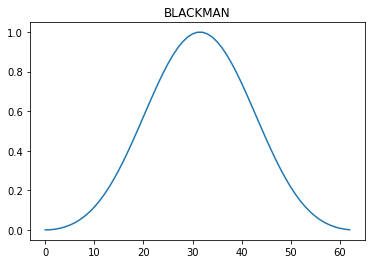

In [23]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = BM1(i,0.16)
    
plt.plot(pz)
plt.title('BLACKMAN')

Text(0.5, 1.0, 'NUTTALL')

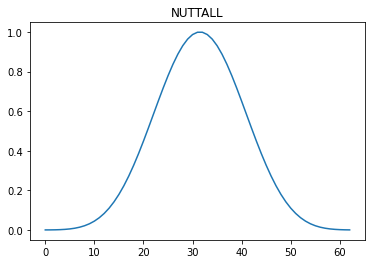

In [24]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = nuttall(i)
    
plt.plot(pz)
plt.title('NUTTALL')

Text(0.5, 1.0, 'BALCKMAN - NUTTALL')

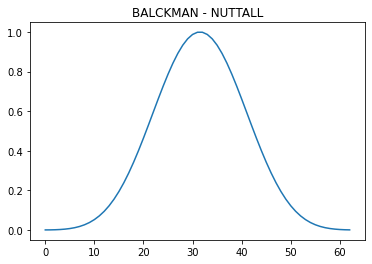

In [25]:
pz = np.zeros(LENGTH)
for i in range(LENGTH):
    pz[i] = nuttall_BM(i)
    
plt.plot(pz)
plt.title('BALCKMAN - NUTTALL')

Text(0.5, 1.0, 'BALCKMAN - HARRIS')

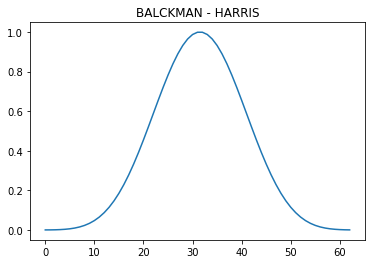

In [26]:
pz = np.zeros(LENGTH)

for i in range(LENGTH):
    pz[i] = Blackman_Harris(i)
    
    
plt.plot(pz)
plt.title('BALCKMAN - HARRIS')

Text(0.5, 1.0, 'FLAT TOP')

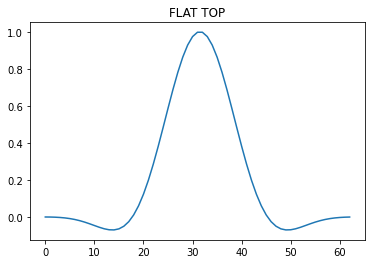

In [27]:
pz = np.zeros(LENGTH)

for i in range(LENGTH):
    pz[i] = flat_top(i)
    
    
plt.plot(pz)
plt.title('FLAT TOP')

Text(0.5, 1.0, 'Genrnalized Normal Window')

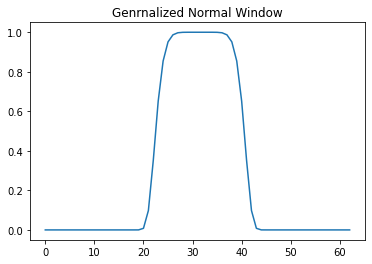

In [69]:
pz = np.zeros(LENGTH,dtype = complex)

for n in range(LENGTH):
    pz[n] = genNORM(n,8,0.3)
plt.plot(pz.real)
plt.title('Genrnalized Normal Window')

In [28]:
def GetHVector(g , win ,POS_alpha = 1 ,BKM_a = 0.16 ):
    tempH = np.zeros(LENGTH,dtype='complex')
    if win == 'TRIG' :
        for n in range(LENGTH):
            tempH[n] = g[n+int(LENGTH/2)]  * trigWINDOW(n) 
    
    elif win == 'PARZ' :
        for n in range(LENGTH):
            tempH[n] = g[n+int(LENGTH/2)]  * parzen(n)   
    
    elif win == 'WELCH' :
        for n in range(LENGTH):
            tempH[n] = g[n+int(LENGTH/2)]  * welch(n)   
    
    elif win == 'SINE' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * sinW(n)  
    
    elif win == 'POS' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * POS(n,POS_alpha)
    
    elif win == 'BKM' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * BM1(n,BKM_a) 
                
    elif win == 'NTL' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * nuttall(n)
                
    elif win == 'BM-NTL' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * nuttall_BM(n)
                
    elif win == 'BM-HR' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * Blackman_Harris(n)
                
    elif win == 'FLTP' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]  * flat_top(n)
    
    
    elif win == 'RCT' :
        for n in range(LENGTH):
                tempH[n] = g[n+int(LENGTH/2)]    
    
    return tempH
        

In [29]:
hwrap = GetHVector(chkR,'TRIG')
hnwrap = GetHVector(chkR,'RCT')
hwrapPZ = GetHVector(chkR,'PARZ')
hwrapWCH = GetHVector(chkR,'WELCH')
hwrapSINE = GetHVector(chkR,'SINE')
hwrapPOS6 = GetHVector(chkR,'POS',POS_alpha = 6)
hwrapBKM = GetHVector(chkR,'BKM')
hwrapNTL = GetHVector(chkR,'NTL')
hwrapBKNT = GetHVector(chkR,'BM-NTL')
hwrapBKHR = GetHVector(chkR,'BM-HR')
hwrapFLTP = GetHVector(chkR,'FLTP')


In [30]:
w = np.linspace(-pi,pi,num = LENGTH)
U = np.zeros(len(w),dtype='complex')
Unw = np.zeros(len(w),dtype='complex')
UPZ = np.zeros(len(w),dtype='complex')
UWCH = np.zeros(len(w),dtype='complex')
USINE = np.zeros(len(w),dtype='complex')
UPOS6 = np.zeros(len(w),dtype='complex')
UBKM = np.zeros(len(w),dtype='complex')
UNTL = np.zeros(len(w),dtype='complex')
UBMNTL = np.zeros(len(w),dtype='complex')
UBMHR = np.zeros(len(w),dtype='complex')
UFLTP = np.zeros(len(w),dtype='complex')

IDEAL = np.zeros(len(w))
for i in range(len(w)):
    U[i] = DTFT(hwrap,w[i],0,LENGTH,typ = 'vector').real
    Unw[i] = DTFT(hnwrap,w[i],0,LENGTH,typ = 'vector').real
    UPZ[i] = DTFT(hwrapPZ,w[i],0,LENGTH,typ = 'vector').real
    UWCH[i] = DTFT(hwrapWCH,w[i],0,LENGTH,typ = 'vector').real
    USINE[i] = DTFT(hwrapSINE,w[i],0,LENGTH,typ = 'vector').real
    UPOS6[i] = DTFT(hwrapPOS6,w[i],0,LENGTH,typ = 'vector').real
    UBKM[i] = DTFT(hwrapBKM,w[i],0,LENGTH,typ = 'vector').real
    UNTL[i] = DTFT(hwrapNTL,w[i],0,LENGTH,typ = 'vector').real
    UBMNTL[i] = DTFT(hwrapBKNT,w[i],0,LENGTH,typ = 'vector').real
    UBMHR[i] = DTFT(hwrapBKHR,w[i],0,LENGTH,typ = 'vector').real
    UFLTP[i] = DTFT(hwrapFLTP,w[i],0,LENGTH,typ = 'vector').real
    IDEAL[i] = H(w[i])
    
    

In [31]:
#plt.plot(w,20*np.log(abs(U)),'g-')
#plt.plot(w,20*np.log(abs(Unw)),'b-')
#plt.plot(w,20*np.log(abs(UPZ)),'k-')
#plt.plot(w,20*np.log(abs(UWCH)),'m-')
#plt.plot(w,20*np.log(abs(IDEAL)+1e-9),'r-')
#plt.plot(w,20*np.log(abs(USINE)),'y-')
#plt.plot(w,20*np.log(abs(UPOS6)),'y-')
#plt.plot(w,20*np.log(abs(UNTL)),'y-')
#plt.plot(w,20*np.log(abs(UBMNTL)),'--')
#plt.plot(w,20*np.log(abs(UBMHR)),'y-')
#plt.plot(w,-3*np.ones(LENGTH),'--')
#plt.plot(w,20*np.log(abs(UFLTP)),'y-')
#plt.plot(w,20*np.log(abs(UBKM)),'y-')

In [32]:
cbuf = CBuff()
OUT = np.zeros(len(IN),dtype = 'complex')
for n in range(len(IN)):
    OUT[n] = cbuf.getOUT(IN[n],hwrapBKM)


Text(0.5, 1.0, 'INPUT with random noise')

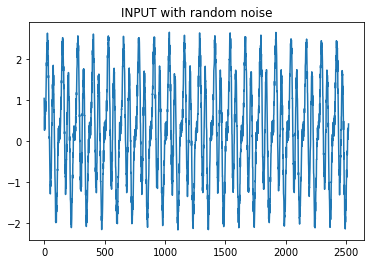

In [33]:
plt.plot(IN)
plt.title('INPUT with random noise')

Text(0.5, 1.0, 'OUTPUT')

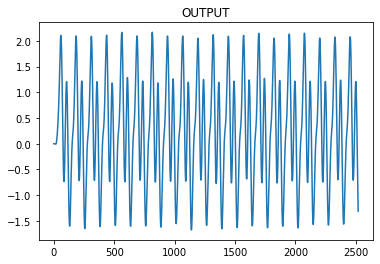

In [34]:
plt.plot(OUT.real)
plt.title('OUTPUT')

In [35]:
print(hwrapBKM.real)

[-2.31544937e-20 -5.13940852e-07 -1.05553597e-05 -4.36462111e-05
 -1.13652197e-04 -2.33528328e-04 -4.13475079e-04 -6.58470357e-04
 -9.65285157e-04 -1.31924785e-03 -1.69116671e-03 -2.03492501e-03
 -2.28630400e-03 -2.36354997e-03 -2.17007655e-03 -1.59948977e-03
 -5.42858793e-04  1.10213893e-03  3.42085854e-03  6.47101898e-03
  1.02727915e-02  1.48007655e-02  1.99788379e-02  2.56788714e-02
  3.17236523e-02  3.78942789e-02  4.39416699e-02  4.96014461e-02
  5.46110578e-02  5.87277486e-02  6.17458069e-02  6.35115648e-02
  6.39347790e-02  6.29953448e-02  6.07447199e-02  5.73019324e-02
  5.28445510e-02  4.75954656e-02  4.18066974e-02  3.57417086e-02
  2.96577665e-02  2.37898556e-02  1.83374097e-02  1.34548047e-02
  9.24613854e-03  5.76438188e-03  3.01456222e-03  9.60285536e-04
 -4.67355538e-04 -1.35957309e-03 -1.81946683e-03 -1.95237873e-03
 -1.85779270e-03 -1.62328360e-03 -1.32072759e-03 -1.00470719e-03
 -7.12813806e-04 -4.67390408e-04 -2.78180569e-04 -1.45356967e-04
 -6.24804272e-05 -1.90692

In [36]:
for i in hwrapBKM.real:
    print(round(i,5))
    print(',')

-0.0
,
-0.0
,
-1e-05
,
-4e-05
,
-0.00011
,
-0.00023
,
-0.00041
,
-0.00066
,
-0.00097
,
-0.00132
,
-0.00169
,
-0.00203
,
-0.00229
,
-0.00236
,
-0.00217
,
-0.0016
,
-0.00054
,
0.0011
,
0.00342
,
0.00647
,
0.01027
,
0.0148
,
0.01998
,
0.02568
,
0.03172
,
0.03789
,
0.04394
,
0.0496
,
0.05461
,
0.05873
,
0.06175
,
0.06351
,
0.06393
,
0.063
,
0.06074
,
0.0573
,
0.05284
,
0.0476
,
0.04181
,
0.03574
,
0.02966
,
0.02379
,
0.01834
,
0.01345
,
0.00925
,
0.00576
,
0.00301
,
0.00096
,
-0.00047
,
-0.00136
,
-0.00182
,
-0.00195
,
-0.00186
,
-0.00162
,
-0.00132
,
-0.001
,
-0.00071
,
-0.00047
,
-0.00028
,
-0.00015
,
-6e-05
,
-2e-05
,
-0.0
,
